In [21]:
# file to make string art out of pictures

import sys
import os
import numpy as np
import cv2
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [22]:
image_path = "C:/Users/brown/Pictures/some pics/forest.jpg"
#image_path = "C:/Users/brown/Pictures/some pics/AMECRO_LizFuller-extracted.jpeg"

image = cv2.imread(image_path)

In [23]:
print(image.shape) 

(1280, 1920, 3)


In [24]:
# make a circle the same size as the image

def starting_circle(image_squared):

    # if the image is not square, take the smaller dimension as the size of the circle
    size = min(image_squared.shape[0], image_squared.shape[1])

    # make a blank image with a black circle of radius size/2
    circle = np.zeros((size, size), np.uint8)
    cv2.circle(circle, (size//2, size//2), size//2, (255, 255, 255), -1)

    return circle



In [43]:
def transform_image(image, scaling_factor=0.2, center_x=None, center_y=None):
    # convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Determine the center of the image if not provided
    if center_x is None:
        center_x = gray_image.shape[1] // 2
    if center_y is None:
        center_y = gray_image.shape[0] // 2

    # if the image is not square, square it:
    if gray_image.shape[0] != gray_image.shape[1]:
        size = min(gray_image.shape[0], gray_image.shape[1])

        # Calculate the square crop coordinates
        half_size = size // 2
        start_x = max(center_x - half_size, 0)
        start_y = max(center_y - half_size, 0)
        end_x = start_x + size
        end_y = start_y + size

        # Ensure the crop is within the image bounds
        end_x = min(end_x, gray_image.shape[1])
        end_y = min(end_y, gray_image.shape[0])
        start_x = end_x - size
        start_y = end_y - size

        # crop the image to be square
        gray_image = gray_image[start_y:end_y, start_x:end_x]

    # reduce the size of the image
    scale_percent = scaling_factor * 100
    width = int(gray_image.shape[1] * scale_percent / 100)
    height = int(gray_image.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(gray_image, dim, interpolation=cv2.INTER_AREA)

    # increase contrast
    contrast = cv2.equalizeHist(resized)

    return contrast

In [52]:
converted_image = transform_image(image, scaling_factor= 2)

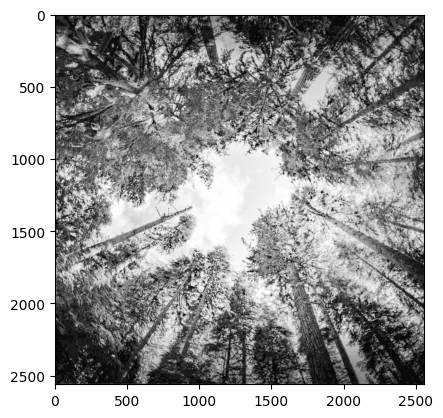

In [53]:
plt.imshow(converted_image, cmap='gray')

In [54]:
converted_image.shape

(2560, 2560)

In [55]:
# find points on the circle:
# function that takes in input the image the number of points to find and returns the coordinates of the points, and draws the points on the image as red dots on another channel

def trace_points(image, num_points):
    # Calculate the center and radius of the circle
    height, width = image.shape[:2]
    center = (width // 2, height // 2)
    radius = min(center[0], center[1], width - center[0], height - center[1])

    # Calculate the angle between points
    angle_step = 360 / num_points

    # Initialize a list to store the points
    points = []

    # Create a copy of the image to draw the points
    image_with_points = np.copy(image)

    # Calculate and draw the points
    for i in range(num_points):
        # Calculate the angle for the current point
        angle = np.deg2rad(i * angle_step)

        # Calculate the x and y coordinates
        x = int(center[0] + radius * np.cos(angle))
        y = int(center[1] + radius * np.sin(angle))

        # Append the point to the list
        points.append((x, y))

        # Draw the point on the image as a red dot
        cv2.circle(image_with_points, (x, y), 1, (0, 0, 255), -1)

    return points, image_with_points

In [62]:
# function that given the image with points and points coordinates, and the coordinate of a current point, returns the coordinates of the next point
# by selecting the point that gives the highest sum of values of the segment between the 2 points. To do so, use torch and the gpu. Compute in parrallel
# the sum of the values of the segment between the current point and all the other points, and select the point that gives the highest sum.

import torch

def find_next_point(image, points, current_point):
    # Ensure the image is a CUDA tensor
    image = torch.tensor(image, device='cuda', dtype=torch.float32) if not isinstance(image, torch.Tensor) else image.to('cuda')
    points_tensor = torch.tensor(points, device='cuda', dtype=torch.float32)
    current_point_tensor = torch.tensor(current_point, device='cuda', dtype=torch.float32).unsqueeze(0)

    # Calculate vectors to all points and their distances
    vectors = points_tensor - current_point_tensor
    distances = torch.norm(vectors, dim=1)
    distance_threshold = 5
    eligible_points_mask = distances > distance_threshold

    # Generate points along the segments
    steps = torch.arange(0, 1, 0.01, device='cuda').view(-1, 1)
    eligible_vectors = vectors[eligible_points_mask].unsqueeze(1)
    segment_points = current_point_tensor + steps * eligible_vectors
    segment_points = segment_points.reshape(-1, 2)

    # Round and clip points to be within image bounds
    segment_points_rounded = torch.round(segment_points).long()
    segment_points_clipped = torch.clamp(segment_points_rounded, 0, min(image.shape[0]-1, image.shape[1]-1))

    # Correct indexing into the image tensor
    pixel_values = image[segment_points_clipped[:, 0], segment_points_clipped[:, 1]]  # Ensure correct ordering of indices
    sums = pixel_values.view(eligible_points_mask.sum().item(), -1).sum(dim=1)

    # Find the index of the point with the highest sum
    next_point_index = torch.argmax(sums).item()
    return next_point_index

In [63]:
def set_line_to_zero(image, start, end):
    """
    Set pixels on the line between start and end points to zero in the image.
    
    Args:
    - image (np.array): The image as a 2D numpy array.
    - start (tuple): The (x, y) start coordinates of the line segment.
    - end (tuple): The (x, y) end coordinates of the line segment.
    """
    # Unpack start and end points
    x0, y0 = start
    x1, y1 = end
    
    # Calculate differences and steps
    dx = abs(x1 - x0)
    dy = -abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx + dy  # error value
    
    while True:
        # Clamp coordinates to image dimensions
        x0_clamped = max(0, min(x0, image.shape[1] - 1))
        y0_clamped = max(0, min(y0, image.shape[0] - 1))
        
        # Set the pixel to 0
        image[y0_clamped, x0_clamped] = 0
        
        # Check if the end has been reached
        if x0 == x1 and y0 == y1:
            break
        
        e2 = 2 * err
        # Move to the next pixel
        if e2 >= dy:
            err += dy
            x0 += sx
        if e2 <= dx:
            err += dx
            y0 += sy

    return image

In [64]:
def stringogh(image, num_points, lines):
    # Find the points on the circle
    points, image_with_points = trace_points(image, num_points)

    # Initialize the string art image as a copy of the input image
    string_art = np.copy(image_with_points)

    # Set the first point as the current point
    current_point = points[0]

    list_of_points = []

    # Iterate over all points
    for i in range(lines):
        # Calculate indices to obscure: current index and 5 neighbors
        current_index = points.index(current_point)
        indices_to_obscure = [(current_index + j) % num_points for j in range(-5, 6)]  # Includes current and 5 neighbors on each side

        # Create a new list of points excluding the obscured ones
        filtered_points = [point for idx, point in enumerate(points) if idx not in indices_to_obscure]

        # Find the next point from the filtered list
        next_point_index = find_next_point(string_art, filtered_points, current_point)  # Adjusted to use filtered list
        next_point = filtered_points[next_point_index]

        # Draw a line between the current and next points
        string_art = set_line_to_zero(string_art, current_point, next_point)

        # Update the current point
        current_point = next_point

        list_of_points.append(current_point)

    return string_art, list_of_points

In [65]:
string_art, list_of_points = stringogh(1 - converted_image, 300, 10)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


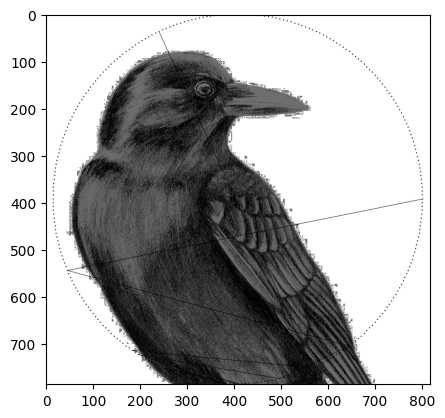

In [ ]:
plt.imshow(1 - string_art, cmap='gray')

In [13]:
# image without the black lines:


In [14]:
# draw the string art on a blank image

def draw_string_art(image, list_of_points):
    # Create a blank image
    string_art = np.zeros_like(image)

    # Draw the string art
    for i in range(1, len(list_of_points)):
        cv2.line(string_art, list_of_points[i-1], list_of_points[i], 255, 1)

    return string_art

string_art_image = draw_string_art(converted_image, list_of_points)


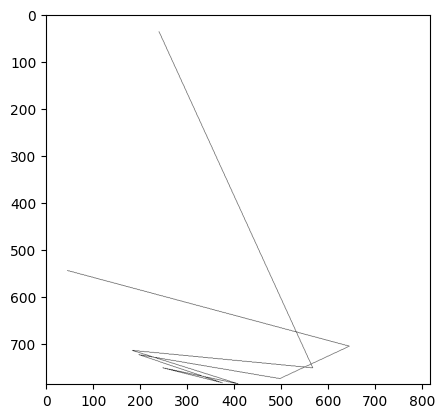

In [15]:
def imshow_black_on_white(image):
    # Ensure image is in float format
    image_float = image.astype(float)
    # Normalize image to have values between 0 and 1
    normalized_image = (image_float - np.min(image_float)) / (np.max(image_float) - np.min(image_float))
    # Invert colors
    inverted_image = 1 - normalized_image
    # Display the image
    plt.imshow(inverted_image, cmap='gray')
    plt.show()
    
imshow_black_on_white(string_art_image)